In [1]:
import numpy as np
import matplotlib.pyplot as plt

import coffea
from coffea.util import load
import hist
import mplhep as hep

def dense_axes(h):
    '''Returns the list of dense axes of a histogram.'''
    dense_axes = []
    if type(h) == dict:
        h = h[list(h.keys())[0]]
    for ax in h.axes:
        if not type(ax) in [hist.axis.StrCategory, hist.axis.IntCategory]:
            dense_axes.append(ax)
    return dense_axes

def stack_sum(stack):
    '''Returns the sum histogram of a stack (`hist.stack.Stack`) of histograms.'''
    if len(stack) == 1:
        return stack[0]
    else:
        htot = stack[0]
        for h in stack[1:]:
            htot = htot + h
        return htot

def get_axis_items(h, axis_name):
    axis = h.axes[axis_name]
    return list( axis.value( range(axis.size) ) )

def get_ratio(h1, h2):
    if type(h1) == hist.Stack:
        h1 = stack_sum(h1)
    if type(h2) == hist.Stack:
        h2 = stack_sum(h2)
    num = h1.values()
    den = h2.values()
    ratio = num / den
    ratio[ratio == 0] = np.nan
    ratio[np.isinf(ratio)] = np.nan
    unc = np.sqrt(num) / den
    unc[np.isnan(ratio)] = np.nan
    
    return ratio, unc

plt.style.use([hep.style.ROOT, {'font.size': 16}])

In [8]:
# QCD split by pt
filename_qcd = "/work/mmarcheg/BTVNanoCommissioning/output/test/qcdsplit_v01/output.coffea"
# QCD split by flavor
#filename_flavor = "/work/mmarcheg/BTVNanoCommissioning/output/test/fatjet_base_2018UL_v109/output.coffea"
filename_flavor = "/work/mmarcheg/BTVNanoCommissioning/output/test/flavorsplit_v12/output.coffea"
# Flavor split reweighted -lf 1
filename_flavor = "/work/mmarcheg/BTVNanoCommissioning/output/test/flavorsplit_particleNetMD_Xbb_2017UL_v02/output.coffea"
output_qcd = load(filename_qcd)
output_flavor = load(filename_flavor)
output_flavor['variables'].keys()

dict_keys(['MuonGood_eta', 'MuonGood_pt', 'MuonGood_phi', 'MuonGood_eta_1', 'MuonGood_pt_1', 'MuonGood_phi_1', 'JetGood_eta', 'JetGood_pt', 'JetGood_phi', 'JetGood_btagDeepFlavB', 'JetGood_eta_1', 'JetGood_pt_1', 'JetGood_phi_1', 'JetGood_btagDeepFlavB_1', 'FatJetGood_eta', 'FatJetGood_pt', 'FatJetGood_phi', 'FatJetGood_mass', 'FatJetGood_msoftdrop', 'FatJetGood_tau21', 'FatJetGood_btagDDBvLV2', 'FatJetGood_btagDDCvLV2', 'FatJetGood_btagDDCvBV2', 'FatJetGood_particleNetMD_Xbb', 'FatJetGood_particleNetMD_Xcc', 'FatJetGood_particleNetMD_Xbb_QCD', 'FatJetGood_particleNetMD_Xcc_QCD', 'FatJetGood_eta_1', 'FatJetGood_pt_1', 'FatJetGood_phi_1', 'FatJetGood_mass_1', 'FatJetGood_msoftdrop_1', 'FatJetGood_tau21_1', 'FatJetGood_btagDDBvLV2_1', 'FatJetGood_btagDDCvLV2_1', 'FatJetGood_btagDDCvBV2_1', 'FatJetGood_particleNetMD_Xbb_1', 'FatJetGood_particleNetMD_Xcc_1', 'FatJetGood_particleNetMD_Xbb_QCD_1', 'FatJetGood_particleNetMD_Xcc_QCD_1', 'events_summass', 'events_logsummass', 'events_sv1mass', 

/tmp/ipykernel_9247/255723758.py:40: RuntimeWarning: invalid value encountered in true_divide
  ratio = num / den
/tmp/ipykernel_9247/255723758.py:43: RuntimeWarning: invalid value encountered in true_divide
  unc = np.sqrt(num) / den


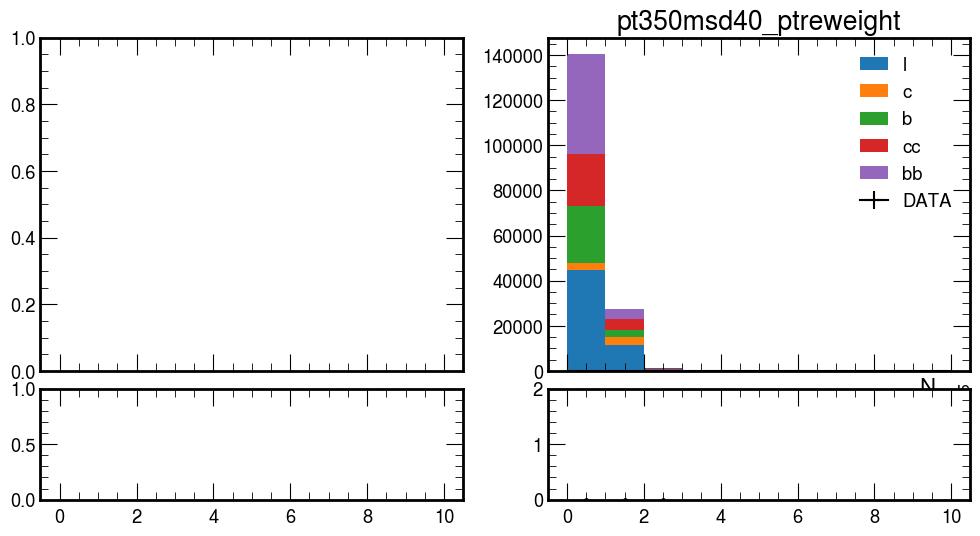

In [12]:
histname = 'nmusj_fatjet2'
year = '2017'

fig, (axes, raxes) = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(hspace=.08)

mc_yield = {}

axes_dict = {
    'qcd'    : (axes[0], raxes[0]),
    'flavor' : (axes[1], raxes[1]),
}

for splitmode, output in zip(['qcd', 'flavor'], [output_qcd, output_flavor]):
    if splitmode == 'qcd' : continue
    ax, rax = axes_dict[splitmode]
    h = output['variables'][histname]
    samples = h.keys()
    samples_data = list(filter(lambda d : 'DATA' in d, samples))
    samples_mc   = list(filter(lambda d : 'DATA' not in d, samples))

    h_mc = h[samples_mc[0]]

    dense_axis = dense_axes(h_mc)[0]
    years      = get_axis_items(h_mc, 'year')
    categories = get_axis_items(h_mc, 'cat')
    variations = get_axis_items(h_mc, 'variation')

    if len(samples_data) == 0:
        isMC = True
    else:
        isMC = False

    cat = 'pt350msd40_ptreweight'
    slicing_mc   = {'year' : year, 'cat' : cat, 'variation' : 'nominal'}
    dict_mc   = {d : h[d][slicing_mc] for d in samples_mc}
    stack_mc = hist.Stack.from_dict(dict_mc)
    x = stack_mc.axes[0].centers
    if not isMC:
        slicing_data = {'year' : year, 'cat' : cat}
        dict_data = {d : h[d][slicing_data] for d in samples_data}
        stack_data = hist.Stack.from_dict(dict_data)
    stack_mc.plot(stack=True, histtype='fill', ax=ax)
    stack_data.plot(stack=True, color='black', ax=ax)
    mc_yield[splitmode] = stack_sum(stack_mc).values()
    ratio, unc = get_ratio(stack_data, stack_mc)
    rax.errorbar(x, ratio, unc, linewidth=0, marker='.', markersize=5, elinewidth=1, color='black')
    #ax.set_xlim(250,500)
    #ax.set_ylim(0,2*10**4)
    rax.set_ylim(0,2)
    #rax.errorbar(x, correction(x), linewidth=0, marker='x', markersize=5, elinewidth=1, color='red')
    #ax.set_yscale("log")
    ax.set_title(cat)
    ax.legend(loc="upper right");

In [ ]:
print(categories)

/tmp/ipykernel_42519/4039644461.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax_mc.errorbar(stack_mc.axes[0].centers, mc_yield['flavor'] / mc_yield['qcd']);


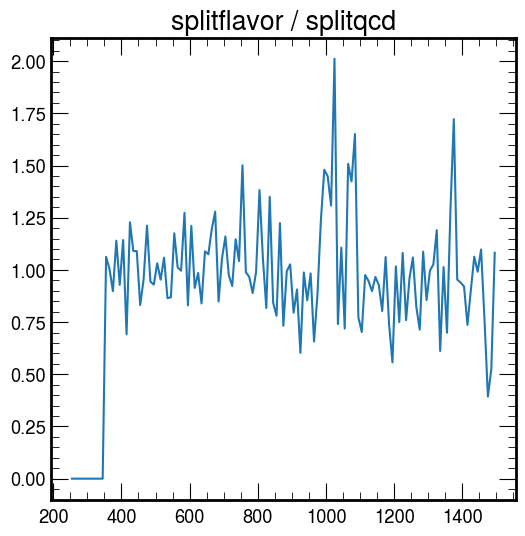

In [66]:
fig_mc, ax_mc = plt.subplots(1, 1, figsize=(6, 6))

ax_mc.errorbar(stack_mc.axes[0].centers, mc_yield['flavor'] / mc_yield['qcd']);
ax_mc.set_title("splitflavor / splitqcd");

In [50]:
output['sumw']

{'inclusive': {'QCD_Pt-170to300': 105829.78946111654,
  'QCD_Pt-300to470': 336945.16790291335,
  'QCD_Pt-470to600': 92132.32322977771,
  'QCD_Pt-600to800': 33429.82512711969,
  'QCD_Pt-800to1000': 6264.220199964631,
  'QCD_Pt-1000toInf': 2113.5386665970777,
  'DATA': 0.0,
  'QCD_Pt-170to300_l': 56336.83151082968,
  'QCD_Pt-170to300_c': 7461.355508014757,
  'QCD_Pt-170to300_b': 3477.430896878524,
  'QCD_Pt-170to300_cc': 23431.535886887345,
  'QCD_Pt-170to300_bb': 15122.635658506217,
  'QCD_Pt-470to600_l': 48898.780231020886,
  'QCD_Pt-470to600_c': 5457.6335054650535,
  'QCD_Pt-470to600_b': 6804.820356214329,
  'QCD_Pt-470to600_cc': 14951.023794638177,
  'QCD_Pt-470to600_bb': 16020.065342439266,
  'QCD_Pt-600to800_l': 19469.820190413986,
  'QCD_Pt-600to800_c': 1994.126872430639,
  'QCD_Pt-600to800_b': 1903.3864763324384,
  'QCD_Pt-600to800_cc': 4731.308047906868,
  'QCD_Pt-600to800_bb': 5331.183540035757,
  'QCD_Pt-1000toInf_l': 1246.272229927824,
  'QCD_Pt-1000toInf_c': 115.459992872607

In [27]:
filename = "/work/mmarcheg/BTVNanoCommissioning/output/test/fatjet_base_2018UL_v109/output.coffea"
output_flavor = load(filename)
output_flavor['sumw']

{'inclusive': {'QCD_Pt-170to300': 143581.81141420043,
  'QCD_Pt-300to470': 385307.0854196064,
  'QCD_Pt-470to600': 90926.39649361586,
  'QCD_Pt-600to800': 33093.297262916894,
  'QCD_Pt-800to1000': 6407.991102302003,
  'QCD_Pt-1000toInf': 2154.47030082814,
  'DATA': 0.0,
  'l': 9.663305029965001e-37,
  'c': 1.3595597123995528e-37,
  'b': 1.928556493936895e-37,
  'cc': 3.4482377647413155e-37,
  'bb': 3.2114017243514134e-37},
 'pt350msd40': {'QCD_Pt-170to300': 52830.97033381545,
  'QCD_Pt-300to470': 185245.7871952499,
  'QCD_Pt-470to600': 49001.961817915464,
  'QCD_Pt-600to800': 18092.994463878284,
  'QCD_Pt-800to1000': 3570.337413382742,
  'QCD_Pt-1000toInf': 1210.380754573273,
  'DATA': 0.0,
  'l': 4.0157812551553575e-37,
  'c': 5.232854129166084e-38,
  'b': 7.502050685982307e-38,
  'cc': 1.8636738229784411e-37,
  'bb': 1.963940279902315e-37},
 'pt350msd60': {'QCD_Pt-170to300': 34306.13205270351,
  'QCD_Pt-300to470': 129649.25875547419,
  'QCD_Pt-470to600': 37347.52065960108,
  'QCD_Pt-

In [17]:
h['DATA'].axes[-1].edges

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
        270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
        360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
        450.,  460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,
        540.,  550.,  560.,  570.,  580.,  590.,  600.,  610.,  620.,
        630.,  640.,  650.,  660.,  670.,  680.,  690.,  700.,  710.,
        720.,  730.,  740.,  750.,  760.,  770.,  780.,  790.,  800.,
        810.,  820.,  830.,  840.,  850.,  860.,  870.,  880.,  890.,
        900.,  910.,  920.,  930.,  940.,  950.,  960.,  970.,  980.,
        990., 1000., 1010., 1020., 1030., 1040., 1050., 1060., 1070.,
       1080., 1090., 1100., 1110., 1120., 1130., 1140., 1150., 1160.,
       1170., 1180., 1190., 1200., 1210., 1220., 1230., 1240., 1250.,
       1260., 1270.,

## Test $p_T$ reweighting

In [23]:
def dense_axes(h):
    '''Returns the list of dense axes of a histogram.'''
    dense_axes = []
    if type(h) == dict:
        h = h[list(h.keys())[0]]
    for ax in h.axes:
        if not type(ax) in [hist.axis.StrCategory, hist.axis.IntCategory]:
            dense_axes.append(ax)
    return dense_axes


def stack_sum(stack):
    '''Returns the sum histogram of a stack (`hist.stack.Stack`) of histograms.'''
    if len(stack) == 1:
        return stack[0]
    else:
        htot = stack[0]
        for h in stack[1:]:
            htot = htot + h
        return htot


def get_axis_items(h, axis_name):
    axis = h.axes[axis_name]
    return list(axis.value(range(axis.size)))


def get_data_mc_ratio(h1, h2):
    if type(h1) == hist.Stack:
        h1 = stack_sum(h1)
    if type(h2) == hist.Stack:
        h2 = stack_sum(h2)
    num = h1.values()
    den = h2.values()
    ratio = num / den
    ratio[ratio == 0] = np.nan
    ratio[np.isinf(ratio)] = np.nan
    unc = np.sqrt(num) / den
    unc[np.isnan(ratio)] = np.nan

    return ratio, unc

In [28]:
from collections import defaultdict
from coffea.lookup_tools.dense_lookup import dense_lookup

pt_low = {
    'inclusive' : 350.,
    'pt350msd40' : 350.,
    'pt350msd60' : 350.,
    'pt350msd80' : 350.,
    'pt350msd100' : 350.,
}

histname_pt = "FatJetGood_pt_1"
accumulator = output_qcd
h = accumulator['variables'][histname_pt]
samples = h.keys()
samples_data = list(filter(lambda d: 'DATA' in d, samples))
samples_mc = list(filter(lambda d: 'DATA' not in d, samples))

h_mc = h[samples_mc[0]]

dense_axis = dense_axes(h_mc)[0]
x = dense_axis.centers
years = get_axis_items(h_mc, 'year')
categories = get_axis_items(h_mc, 'cat')
variations = get_axis_items(h_mc, 'variation')

corr_dict = defaultdict(float)

for year in years:
    for cat in categories:
        #slicing_mc = {'year': year, 'cat': cat}
        slicing_mc_nominal = {'year': year, 'cat': cat, 'variation': 'nominal'}
        #dict_mc = {d: h[d][slicing_mc] for d in samples_mc}
        dict_mc_nominal = {d: h[d][slicing_mc_nominal] for d in samples_mc}
        #stack_mc = hist.Stack.from_dict(dict_mc)
        stack_mc_nominal = hist.Stack.from_dict(dict_mc_nominal)

        if 'era' in h[samples_data[0]].axes.name:
            slicing_data = {'year': '2018', 'cat': cat, 'era': sum}
        else:
            slicing_data = {'year': '2018', 'cat': cat}
        dict_data = {d: h[d][slicing_data] for d in samples_data}
        stack_data = hist.Stack.from_dict(dict_data)
        if len(stack_data) > 1:
            raise NotImplementedError
        else:
            h_data = stack_data[0]
        ratio, unc = get_data_mc_ratio(stack_data, stack_mc_nominal)
        mod_ratio  = np.nan_to_num(ratio)
        bins = dense_axis.edges
        if cat not in pt_low.keys():
            pt_low[cat] = 350.
        mod_ratio[bins[:-1] < pt_low[cat]] = 1
        mod_ratio[bins[:-1] > 1500] = 1

        efflookup = dense_lookup(mod_ratio, [bins])
        print(efflookup(np.array([50, 100, 400, 500, 2000, 10000])))
        corr_dict.update({ cat : efflookup })

[1.         1.         0.60232716 0.7321112  0.26772335 0.26772335]
[1.         1.         0.60232716 0.7321112  0.26772335 0.26772335]
[1.         1.         0.62545069 0.78931415 0.         0.        ]
[1.         1.         0.62544828 0.78927374 0.16216963 0.16216963]
[1. 1. 0. 0. 0. 0.]
[1.         1.         0.         0.         0.16216963 0.16216963]
[1.         1.         0.         0.         0.16216963 0.16216963]
[1.         1.         0.61368652 0.78760434 0.         0.        ]
[1.         1.         0.61368383 0.78755852 0.17598398 0.17598398]
[1. 1. 0. 0. 0. 0.]
[1.         1.         0.         0.         0.17598398 0.17598398]
[1.         1.         0.         0.         0.17598398 0.17598398]
[1.         1.         0.62938492 0.79142757 0.         0.        ]
[1.         1.         0.6293824  0.79138576 0.16426464 0.16426464]
[1. 1. 0. 0. 0. 0.]
[1.         1.         0.         0.         0.16426464 0.16426464]
[1.         1.         0.         0.         0.16426464 

/tmp/ipykernel_53853/2101293678.py:35: RuntimeWarning: invalid value encountered in true_divide
  ratio = num / den
/tmp/ipykernel_53853/2101293678.py:38: RuntimeWarning: invalid value encountered in true_divide
  unc = np.sqrt(num) / den
/tmp/ipykernel_53853/2101293678.py:35: RuntimeWarning: divide by zero encountered in true_divide
  ratio = num / den
/tmp/ipykernel_53853/2101293678.py:38: RuntimeWarning: divide by zero encountered in true_divide
  unc = np.sqrt(num) / den


In [51]:
correction = corr_dict['pt350msd40']

In [50]:
correction(349)

1.0